In [17]:
import os
import sys
sys.path.append("../..")
os.environ["CUDA_VISIBLE_DEVICES"]="4"
from openTSNE import TSNE
import torch

from train_router_mdeberta_v4 import RouterDataset, RouterModule
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import T5EncoderModel, T5Tokenizer, AutoTokenizer, DebertaV2Model

# dataset_paths = ["../../datasets/all_score_model7/mmlu_train.json","../../datasets/all_score_model7/gsm8k-train.json", "../../datasets/all_score_model7/cmmlu_train.json", "../../datasets/all_score_model7/arc_challenge_train.json", "../../datasets/all_score_model7/humaneval_train.json",]

# dataset_paths = ["../../datasets/split2_model7/mmlu_train.json","../../datasets/split2_model7/gsm8k-train.json", "../../datasets/split2_model7/cmmlu_train.json", "../../datasets/split2_model7/arc_challenge_train.json", "../../datasets/split2_model7/humaneval_train.json",]

dataset_paths = ["../../datasets/split2_model7_cluster/mmlu_train.json","../../datasets/split2_model7_cluster/gsm8k-train.json", "../../datasets/split2_model7_cluster/cmmlu_train.json", "../../datasets/split2_model7_cluster/arc_challenge_train.json", "../../datasets/split2_model7_cluster/humaneval_train.json",]

data_types = [ "multi_attempt", "probability", "probability", "probability", "multi_attempt"]

# dataset_paths = ["../../datasets/split2_model7/gsm8k-train.json"]
# data_types = ["multi_attempt"]

tokenizer = AutoTokenizer.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base", truncation_side='left', padding=True)
encoder_model = DebertaV2Model.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base").to("cuda")

router_datasets = [RouterDataset(data_path, data_type=data_types[i], dataset_id=i, size=2000) for i, data_path in enumerate(dataset_paths)]
for router_dataset in router_datasets:
    router_dataset.register_tokenizer(tokenizer)
router_dataset = ConcatDataset(router_datasets)
router_dataloader = DataLoader(router_dataset, batch_size=64)

/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [18]:
router_model = RouterModule(encoder_model, hidden_state_dim=768, node_size=len(router_datasets[0].router_node), similarity_function="cos").to("cpu")

# state_dict = torch.load("/data/home/chensh/projects/LLM_router/logs/router_debug/split2_model5/old/sample_loss_weight_1_cos_top_k_1_last_k_3_learning_rate_0.00005_step_500_t_1/model.pth")
# router_model.load_state_dict(state_dict)
router_model.to('cuda')


RouterModule(
  (backbone): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              

In [19]:
all_hidden_states = []
dataset_set_ids = []
cluster_ids = []
predicts = []
with torch.no_grad():
    for i, batch in enumerate(router_dataloader):
        input, _, dataset_id, cluster_id = batch
        input.to("cuda")
        predict, hidden_states = router_model(**input)
        dataset_set_ids.append(dataset_id)
        cluster_ids.append(cluster_id)
        predicts.append(predict)
        all_hidden_states.append(hidden_states)

# with torch.no_grad():
#     for i, batch in enumerate(router_dataloader):
#         input, _, dataset_id = batch
#         input.to("cuda")
#         predict, hidden_states = router_model(**input)
#         dataset_set_ids.append(dataset_id)
#         predicts.append(predict)
#         all_hidden_states.append(hidden_states)

all_hidden_states = torch.concat(all_hidden_states)
predicts = torch.concat(predicts)
cluster_ids = torch.concat(cluster_ids).numpy() 
_, max_index = torch.max(predicts, dim=1)

In [36]:
for i in range(200):

    from MulticoreTSNE import MulticoreTSNE as M_TSNE
    from openTSNE import TSNE
    np_hidden_states = all_hidden_states.cpu().numpy()
    tsne_result = M_TSNE(n_components=2, n_jobs=12).fit_transform(np_hidden_states)
    # tsne_result = TSNE(n_components=2).fit(np_hidden_states)
    import numpy as np
    np_dataset_ids = torch.concat(dataset_set_ids).numpy()
    model_ids = max_index.cpu().numpy()

    tsne_result_x = [item[0] for item in tsne_result]
    tsne_result_y = [item[1] for item in tsne_result]


    from matplotlib import pyplot as plt
    import numpy as np
    from matplotlib.patches import Patch
    from matplotlib.colors import Normalize

    plt.figure()

    # 假设 tsne_result_x 和 tsne_result_y 是你的数据点的坐标数组
    # 假设 np_ids 是每个点的类别标签，每个类别的标签是唯一的整数

    np_ids = np_dataset_ids

    index_4 = np_ids == 4
    index_2 = np_ids == 2
    np_ids[index_4] = 2
    np_ids[index_2] = 4

    # scatter = plt.scatter(tsne_result_x[:-2000], tsne_result_y[:-2000], c=np_ids[:-2000], cmap='viridis', s=8)
    # plt.scatter(tsne_result_x[-2000:], tsne_result_y[-2000:], color = '#F04E4E', s=8)
    scatter = plt.scatter(tsne_result_x, tsne_result_y, c=np_ids, cmap='viridis', s=8)

    # 创建 colorbar
    # cbar = plt.colorbar(scatter)

    # 获取颜色映射和归一化实例
    cmap = plt.cm.viridis
    norm = Normalize(vmin=np_ids.min(), vmax=np_ids.max())

    # 创建图例的patches
    # labels=['MMLU model 1','MMLU model 2','MMLU model 3','MMLU model 4','MMLU model 5']
    legend_patches = [Patch(color=cmap(norm(0)), label='MMLU'),
                    Patch(color=cmap(norm(1)), label='GSM8K'),
                    Patch(color=cmap(norm(4)), label='CMMLU'),
                    Patch(color=cmap(norm(3)), label='ARC-C'),
                    Patch(color=cmap(norm(2)), label='HumanEval'),
                    ]

    # 添加图例
    plt.legend(handles=legend_patches)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.savefig(f"../../figures/tsne_cluster/task_{i}.pdf", dpi=800, bbox_inches = 'tight')

    plt.figure()

    # 假设 tsne_result_x 和 tsne_result_y 是你的数据点的坐标数组
    # 假设 np_ids 是每个点的类别标签，每个类别的标签是唯一的整数

    # scatter = plt.scatter(tsne_result_x[:-2000], tsne_result_y[:-2000], c=np_ids[:-2000], cmap='viridis', s=8)
    # plt.scatter(tsne_result_x[-2000:], tsne_result_y[-2000:], color = '#F04E4E', s=8)
    scatter = plt.scatter(tsne_result_x, tsne_result_y, c=cluster_ids, cmap='viridis', s=10)

    # 创建 colorbar
    # cbar = plt.colorbar(scatter)

    # 获取颜色映射和归一化实例
    cmap = plt.cm.viridis
    norm = Normalize(vmin=np_ids.min(), vmax=np_ids.max())

    # 创建图例的patches
    labels=['MMLU','GSM8K','CMMLU','ARC-C','HumanEval']
    legend_patches = [Patch(color=cmap(norm(i)), label=f'Cluster {i+1}') for  i, value in enumerate(labels)]
    # legend_patches = [Patch(color=cmap(norm(i)), label=f'{value}') for  i, value in enumerate(labels)]
    # legend_patches.append(Patch(color= '#F04E4E', label=f'{labels[-1]}'))

    # 添加图例
    plt.legend(handles=legend_patches)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)

    plt.savefig(f"../../figures/tsne_cluster/cluster_{i}.pdf", dpi=800, bbox_inches = 'tight')


/tmp/ipykernel_3686345/1436266643.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


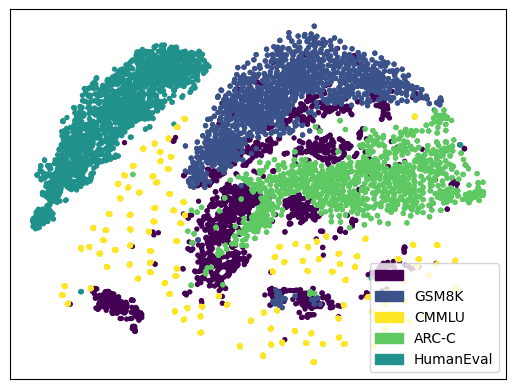

[0 0 0 ... 4 4 4]


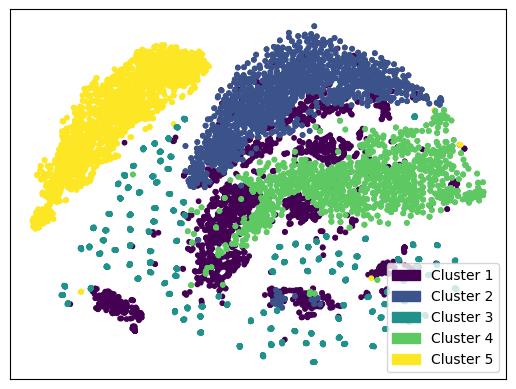

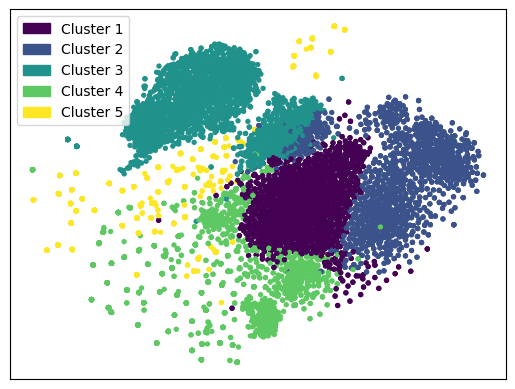

In [58]:
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import random as random

n_clusters_list = [5]

seed = 42
random.seed(seed)
np.random.seed(seed)

for n_clusters in n_clusters_list:
    x = tsne_result2
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000)

    # 对样本数据进行聚类
    kmeans.fit(x)

    # 获取聚类结果
    kmeans_labels = kmeans.labels_.tolist()
    kmeans_labels = np.array(kmeans_labels)

    # import json
    # import os

    # labels_split = [labels[i*2000: (i+1)*2000] for i in range(len(dataset_paths))]
    # base_output_path = f"/data/home/chensh/projects/LLM_router/datasets/all_score_model7_cluster"
    # os.makedirs(base_output_path, exist_ok=True)


    # for i, data_path in enumerate(dataset_paths) :
    #     cluster_ids = labels_split[i]
        
    #     with open(data_path, 'r') as f:
    #         if data_path.endswith('.json'):
    #             sample_list = json.load(f)
    #     new_sample_list = []
    #     for j, sample in enumerate(sample_list):
    #         if j >= 2000:
    #             break
    #         new_sample = sample 
    #         new_sample['cluster_id'] = cluster_ids[j]
    #         new_sample_list.append(new_sample)
    #     # with open(os.path.join(base_output_path, data_path.split('/')[-1]), "w" ) as f:
    #     #     json.dump(new_sample_list ,f)


from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import Normalize

# 假设 tsne_result_x 和 tsne_result_y 是你的数据点的坐标数组
# 假设 np_ids 是每个点的类别标签，每个类别的标签是唯一的整数

scatter = plt.scatter(tsne_result_x, tsne_result_y, c=kmeans_labels, cmap='viridis', s=8)

# 创建 colorbar
# cbar = plt.colorbar(scatter)

# 获取颜色映射和归一化实例
cmap = plt.cm.viridis
norm = Normalize(vmin=kmeans_labels.min(), vmax=kmeans_labels.max())

# 创建图例的patches
# labels=['MMLU','GSM8K','CMMLU','ARC-C','HumanEval']
legend_patches = [Patch(color=cmap(norm(i)), label=f'Cluster {i+1}') for  i, value in enumerate(labels)]

# 添加图例
plt.legend(handles=legend_patches)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

save_path = "/data/home/chensh/projects/LLM_router/figures/TSNE_cluster.pdf"
plt.savefig(save_path, dpi=800, bbox_inches = 'tight')


In [59]:
# import json
# with open("/data/home/chensh/projects/LLM_router/datasets/split2_model7/cmmlu_train.json", 'r') as f:
#     jsonfile = json.load(f)
# print(len(jsonfile))

In [2]:
# load sample list
import os
import sys
sys.path.append("../..")
os.environ["CUDA_VISIBLE_DEVICES"]="4"
from openTSNE import TSNE
import torch

from train_router_mdeberta_v4 import RouterDataset, RouterModule
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import T5EncoderModel, T5Tokenizer, AutoTokenizer, DebertaV2Model

dataset_paths = ["../../datasets/split2_model7_cluster/mmlu_train.json","../../datasets/split2_model7_cluster/gsm8k-train.json", "../../datasets/split2_model7_cluster/cmmlu_train.json", "../../datasets/split2_model7_cluster/arc_challenge_train.json", "../../datasets/split2_model7_cluster/humaneval_train.json",]

data_types = [ "multi_attempt", "probability", "probability", "probability", "multi_attempt"]

# dataset_paths = ["../../datasets/split2_model7/gsm8k-train.json"]
# data_types = ["multi_attempt"]

tokenizer = AutoTokenizer.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base", truncation_side='left', padding=True)
encoder_model = DebertaV2Model.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base").to("cuda")
# trained_router_path = "/data/home/chensh/projects/LLM_router/logs/router_debug/ablation_clw/clw_1/slw_0_clw_1_clw_2_0_cos_tk_3_lk_3_lr_5e-5_step_1000_t_1_seed_5/best_training_model.pth"

trained_router_path = "/data/home/chensh/projects/LLM_router/logs/router_debug/ablation_slw/slw_0/slw_0_clw_0_clw_2_0_cos_tk_3_lk_3_lr_5e-5_step_1000_t_1_seed_5/best_training_model.pth"

router_datasets = [RouterDataset(data_path, data_type=data_types[i], dataset_id=i, size=2000) for i, data_path in enumerate(dataset_paths)]
for router_dataset in router_datasets:
    router_dataset.register_tokenizer(tokenizer)
router_dataset = ConcatDataset(router_datasets)
router_dataloader = DataLoader(router_dataset, batch_size=64)


router_model = RouterModule(encoder_model, hidden_state_dim=768, node_size=len(router_datasets[0].router_node), similarity_function="cos").to("cpu")
router_model.to('cuda')

state_dict = torch.load(trained_router_path)
router_model.load_state_dict(state_dict)


# get predicted label 
all_hidden_states = []
dataset_set_ids = []
cluster_ids = []
predicts = []
with torch.no_grad():
    for i, batch in enumerate(router_dataloader):
        input, _, dataset_id, cluster_id = batch
        input.to("cuda")
        predict, hidden_states = router_model(**input)
        dataset_set_ids.append(dataset_id)
        cluster_ids.append(cluster_id)
        predicts.append(predict)
        all_hidden_states.append(hidden_states)


all_hidden_states = torch.concat(all_hidden_states)
predicts = torch.concat(predicts)
cluster_ids = torch.concat(cluster_ids).numpy() 
_, max_index = torch.max(predicts, dim=1)

KeyboardInterrupt: 

In [ ]:
from MulticoreTSNE import MulticoreTSNE as M_TSNE
from openTSNE import TSNE
np_hidden_states = all_hidden_states.cpu().numpy()
tsne_result = M_TSNE(n_components=2, n_jobs=12).fit_transform(np_hidden_states)
# tsne_result = TSNE(n_components=2).fit(np_hidden_states)
import numpy as np
np_dataset_ids = torch.concat(dataset_set_ids).numpy()
model_ids = max_index.cpu().numpy()

tsne_result_x = [item[0] for item in tsne_result]
tsne_result_y = [item[1] for item in tsne_result]


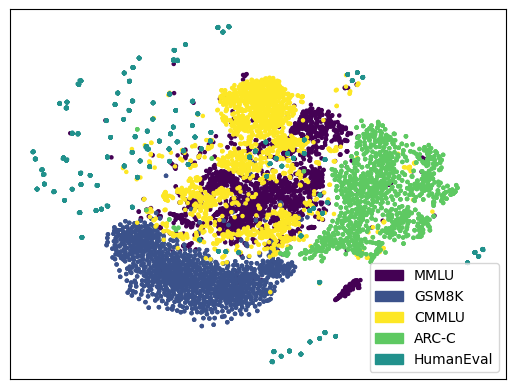

In [7]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import Normalize

# 假设 tsne_result_x 和 tsne_result_y 是你的数据点的坐标数组
# 假设 np_ids 是每个点的类别标签，每个类别的标签是唯一的整数

np_ids = np_dataset_ids

index_4 = np_ids == 4
index_2 = np_ids == 2
np_ids[index_4] = 2
np_ids[index_2] = 4

# scatter = plt.scatter(tsne_result_x[:-2000], tsne_result_y[:-2000], c=np_ids[:-2000], cmap='viridis', s=8)
# plt.scatter(tsne_result_x[-2000:], tsne_result_y[-2000:], color = '#F04E4E', s=8)
scatter = plt.scatter(tsne_result_x, tsne_result_y, c=np_ids, cmap='viridis', s=5)

# 创建 colorbar
# cbar = plt.colorbar(scatter)

# 获取颜色映射和归一化实例
cmap = plt.cm.viridis
norm = Normalize(vmin=np_ids.min(), vmax=np_ids.max())

# 创建图例的patches
# labels=['MMLU model 1','MMLU model 2','MMLU model 3','MMLU model 4','MMLU model 5']
legend_patches = [Patch(color=cmap(norm(0)), label='MMLU'),
                  Patch(color=cmap(norm(1)), label='GSM8K'),
                  Patch(color=cmap(norm(4)), label='CMMLU'),
                  Patch(color=cmap(norm(3)), label='ARC-C'),
                  Patch(color=cmap(norm(2)), label='HumanEval'),
                  ]

# 添加图例
plt.legend(handles=legend_patches)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
# plt.savefig("../../figures/sample_distribution_wo_sample_sample_loss.pdf", dpi=800, bbox_inches = 'tight')

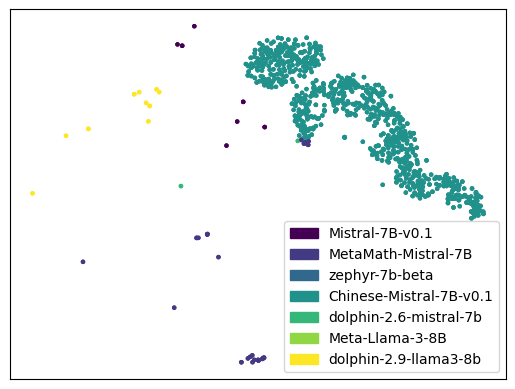

In [41]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import Normalize

# 假设 tsne_result_x 和 tsne_result_y 是你的数据点的坐标数组
# 假设 np_ids 是每个点的类别标签，每个类别的标签是唯一的整数

# index_4 = np_ids == 4
# index_2 = np_ids == 2
# np_ids[index_4] = 2
# np_ids[index_2] = 4

# scatter = plt.scatter(tsne_result_x[:-2000], tsne_result_y[:-2000], c=np_ids[:-2000], cmap='viridis', s=8)
# plt.scatter(tsne_result_x[-2000:], tsne_result_y[-2000:], color = '#F04E4E', s=8)
# scatter = plt.scatter(tsne_result_x, tsne_result_y, c=np_ids, cmap='viridis', s=5)
# scatter_main = plt.scatter(tsne_result_x[:2000], tsne_result_y[:2000], color = "green", s=5, alpha = 0.1, marker='.')
scatter_main = plt.scatter(tsne_result_x[6000:8000], tsne_result_y[6000:8000], c=model_ids[6000:8000], cmap='viridis', s=5)
# scatter_main = plt.scatter(tsne_result_x[4000:], tsne_result_y[4000:], color = "green", s=5, alpha = 0.1, marker='.')

# 创建 colorbar
# cbar = plt.colorbar(scatter)

# 获取颜色映射和归一化实例
cmap = plt.cm.viridis
norm = Normalize(vmin=model_ids.min(), vmax=model_ids.max())

# 创建图例的patches
labels=['Mistral-7B-v0.1','MetaMath-Mistral-7B',"zephyr-7b-beta",'Chinese-Mistral-7B-v0.1',"dolphin-2.6-mistral-7b", "Meta-Llama-3-8B", "dolphin-2.9-llama3-8b"]
# legend_patches = [Patch(color=cmap(norm(0)), label=labels[0]),
#                   Patch(color=cmap(norm(1)), label='GSM8K'),
#                   Patch(color=cmap(norm(4)), label='CMMLU'),
#                   Patch(color=cmap(norm(3)), label='ARC-C'),
#                   Patch(color=cmap(norm(2)), label='HumanEval'),
#                   ]
legend_patches = [Patch(color=cmap(norm(i)), label=labels[i]) for i in range (7)]

# 添加图例
# plt.legend(handles=legend_patches)
plt.legend(handles=legend_patches)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

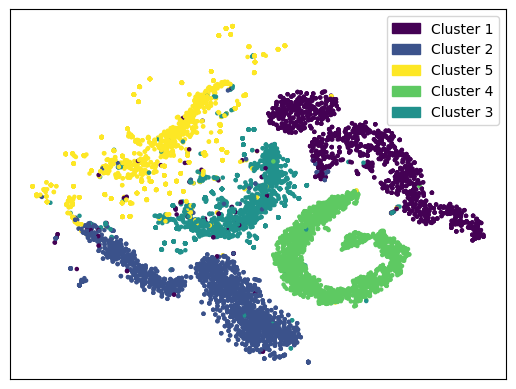

In [44]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import Normalize

# 假设 tsne_result_x 和 tsne_result_y 是你的数据点的坐标数组
# 假设 np_ids 是每个点的类别标签，每个类别的标签是唯一的整数

index_4 = np_ids == 4
index_2 = np_ids == 2
np_ids[index_4] = 2
np_ids[index_2] = 4

# scatter = plt.scatter(tsne_result_x[:-2000], tsne_result_y[:-2000], c=np_ids[:-2000], cmap='viridis', s=8)
# plt.scatter(tsne_result_x[-2000:], tsne_result_y[-2000:], color = '#F04E4E', s=8)
scatter = plt.scatter(tsne_result_x, tsne_result_y, c=cluster_ids, cmap='viridis', s=5)

# 创建 colorbar
# cbar = plt.colorbar(scatter)

# 获取颜色映射和归一化实例
cmap = plt.cm.viridis
norm = Normalize(vmin=cluster_ids.min(), vmax=cluster_ids.max())

# 创建图例的patches
# labels=['MMLU model 1','MMLU model 2','MMLU model 3','MMLU model 4','MMLU model 5']
legend_patches = [Patch(color=cmap(norm(0)), label='Cluster 1'),
                  Patch(color=cmap(norm(1)), label='Cluster 2'),
                  Patch(color=cmap(norm(4)), label='Cluster 5'),
                  Patch(color=cmap(norm(3)), label='Cluster 4'),
                  Patch(color=cmap(norm(2)), label='Cluster 3'),
                  ]

# 添加图例
plt.legend(handles=legend_patches)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

In [1]:
# Plot the groundth of training queries


import os
import sys
sys.path.append("../..")
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from openTSNE import TSNE
import torch

from train_router_mdeberta_v4 import RouterDataset, RouterModule
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import T5EncoderModel, T5Tokenizer, AutoTokenizer, DebertaV2Model

dataset_paths = ["../../datasets/split2_model7_cluster/mmlu_train.json","../../datasets/split2_model7_cluster/gsm8k-train.json", "../../datasets/split2_model7_cluster/cmmlu_train.json", "../../datasets/split2_model7_cluster/arc_challenge_train.json", "../../datasets/split2_model7_cluster/humaneval_train.json",]

data_types = [ "multi_attempt", "probability", "probability", "probability", "multi_attempt"]

# dataset_paths = ["../../datasets/split2_model7/gsm8k-train.json"]
# data_types = ["multi_attempt"]

tokenizer = AutoTokenizer.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base", truncation_side='left', padding=True)
encoder_model = DebertaV2Model.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base").to("cuda")
# trained_router_path = "/data/home/chensh/projects/LLM_router/logs/router_debug/ablation_clw/clw_1/slw_0_clw_1_clw_2_0_cos_tk_3_lk_3_lr_5e-5_step_1000_t_1_seed_5/best_training_model.pth"

router_datasets = [RouterDataset(data_path, data_type=data_types[i], dataset_id=i, size=2000) for i, data_path in enumerate(dataset_paths)]
for router_dataset in router_datasets:
    router_dataset.register_tokenizer(tokenizer)
router_dataset = ConcatDataset(router_datasets)
router_dataloader = DataLoader(router_dataset, batch_size=64)


router_model = RouterModule(encoder_model, hidden_state_dim=768, node_size=len(router_datasets[0].router_node), similarity_function="cos").to("cpu")
router_model.to('cuda')

# state_dict = torch.load(trained_router_path)
# router_model.load_state_dict(state_dict)


# get predicted label 
all_hidden_states = []
dataset_set_ids = []
cluster_ids = []
predicts = []
with torch.no_grad():
    for i, batch in enumerate(router_dataloader):
        input, _, dataset_id, cluster_id = batch
        input.to("cuda")
        predict, hidden_states = router_model(**input)
        dataset_set_ids.append(dataset_id)
        cluster_ids.append(cluster_id)
        predicts.append(predict)
        all_hidden_states.append(hidden_states)


all_hidden_states = torch.concat(all_hidden_states)
predicts = torch.concat(predicts)
cluster_ids = torch.concat(cluster_ids).numpy() 
_, max_index = torch.max(predicts, dim=1)

/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
from MulticoreTSNE import MulticoreTSNE as M_TSNE
from openTSNE import TSNE
np_hidden_states = all_hidden_states.cpu().numpy()
tsne_result = M_TSNE(n_components=2, n_jobs=12).fit_transform(np_hidden_states)
# tsne_result = TSNE(n_components=2).fit(np_hidden_states)
import numpy as np
np_dataset_ids = torch.concat(dataset_set_ids).numpy()
model_ids = max_index.cpu().numpy()

tsne_result_x = [item[0] for item in tsne_result]
tsne_result_y = [item[1] for item in tsne_result]

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import Normalize

# 假设 tsne_result_x 和 tsne_result_y 是你的数据点的坐标数组
# 假设 np_ids 是每个点的类别标签，每个类别的标签是唯一的整数

index_4 = np_ids == 4
index_2 = np_ids == 2
np_ids[index_4] = 2
np_ids[index_2] = 4

# scatter = plt.scatter(tsne_result_x[:-2000], tsne_result_y[:-2000], c=np_ids[:-2000], cmap='viridis', s=8)
# plt.scatter(tsne_result_x[-2000:], tsne_result_y[-2000:], color = '#F04E4E', s=8)
scatter = plt.scatter(tsne_result_x, tsne_result_y, c=cluster_ids, cmap='viridis', s=5)

# 创建 colorbar
# cbar = plt.colorbar(scatter)

# 获取颜色映射和归一化实例
cmap = plt.cm.viridis
norm = Normalize(vmin=cluster_ids.min(), vmax=cluster_ids.max())

# 创建图例的patches
# labels=['MMLU model 1','MMLU model 2','MMLU model 3','MMLU model 4','MMLU model 5']
legend_patches = [Patch(color=cmap(norm(0)), label='Cluster 1'),
                  Patch(color=cmap(norm(1)), label='Cluster 2'),
                  Patch(color=cmap(norm(4)), label='Cluster 5'),
                  Patch(color=cmap(norm(3)), label='Cluster 4'),
                  Patch(color=cmap(norm(2)), label='Cluster 3'),
                  ]

# 添加图例
plt.legend(handles=legend_patches)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

NameError: name 'np_ids' is not defined

/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


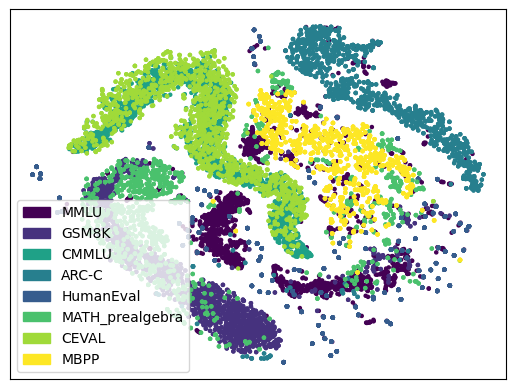

In [1]:
# load sample list
import os
import sys
sys.path.append("../..")
os.environ["CUDA_VISIBLE_DEVICES"]="6"
from openTSNE import TSNE
import torch

from train_router_mdeberta_v4 import RouterDataset, RouterModule
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import T5EncoderModel, T5Tokenizer, AutoTokenizer, DebertaV2Model

dataset_paths = ["../../datasets/split2_model7_cluster/mmlu_train.json","../../datasets/split2_model7_cluster/gsm8k-train.json", "../../datasets/split2_model7_cluster/cmmlu_train.json", "../../datasets/split2_model7_cluster/arc_challenge_train.json", "../../datasets/split2_model7_cluster/humaneval_train.json", "/data/home/chensh/projects/LLM_router/datasets/split2_model7/MATH_prealgebra.json", "/data/home/chensh/projects/LLM_router/datasets/split2_model7/ceval.json", "/data/home/chensh/projects/LLM_router/datasets/split2_model7/mbpp.json" ]

data_types = [ "multi_attempt", "probability", "probability", "probability", "multi_attempt", "multi_attempt",  "probability",  "multi_attempt"]

# dataset_paths = ["../../datasets/split2_model7/gsm8k-train.json"]
# data_types = ["multi_attempt"]

tokenizer = AutoTokenizer.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base", truncation_side='left', padding=True)
encoder_model = DebertaV2Model.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base").to("cuda")
trained_router_path = "/data/home/chensh/projects/LLM_router/logs/router_debug/ablation_clw/clw_1/slw_0_clw_1_clw_2_0_cos_tk_3_lk_3_lr_5e-5_step_1000_t_1_seed_5/best_training_model.pth"

# trained_router_path = "/data/home/chensh/projects/LLM_router/logs/router_debug/ablation_slw/slw_0/slw_0_clw_0_clw_2_0_cos_tk_3_lk_3_lr_5e-5_step_1000_t_1_seed_5/best_training_model.pth"

router_datasets = [RouterDataset(data_path, data_type=data_types[i], dataset_id=i, size=2000) for i, data_path in enumerate(dataset_paths)]
for router_dataset in router_datasets:
    router_dataset.register_tokenizer(tokenizer)
router_dataset = ConcatDataset(router_datasets)
router_dataloader = DataLoader(router_dataset, batch_size=64)


router_model = RouterModule(encoder_model, hidden_state_dim=768, node_size=len(router_datasets[0].router_node), similarity_function="cos").to("cpu")
router_model.to('cuda')

state_dict = torch.load(trained_router_path)
router_model.load_state_dict(state_dict)


# get predicted label 
all_hidden_states = []
dataset_set_ids = []
cluster_ids = []
predicts = []
with torch.no_grad():
    for i, batch in enumerate(router_dataloader):
        input, _, dataset_id, cluster_id = batch
        input.to("cuda")
        predict, hidden_states = router_model(**input)
        dataset_set_ids.append(dataset_id)
        cluster_ids.append(cluster_id)
        predicts.append(predict)
        all_hidden_states.append(hidden_states)


all_hidden_states = torch.concat(all_hidden_states)
predicts = torch.concat(predicts)
cluster_ids = torch.concat(cluster_ids).numpy() 
_, max_index = torch.max(predicts, dim=1)


from MulticoreTSNE import MulticoreTSNE as M_TSNE
from openTSNE import TSNE
np_hidden_states = all_hidden_states.cpu().numpy()
tsne_result = M_TSNE(n_components=2, n_jobs=12).fit_transform(np_hidden_states)
# tsne_result = TSNE(n_components=2).fit(np_hidden_states)
import numpy as np
np_dataset_ids = torch.concat(dataset_set_ids).numpy()
model_ids = max_index.cpu().numpy()

tsne_result_x = [item[0] for item in tsne_result]
tsne_result_y = [item[1] for item in tsne_result]


from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import Normalize

# 假设 tsne_result_x 和 tsne_result_y 是你的数据点的坐标数组
# 假设 np_ids 是每个点的类别标签，每个类别的标签是唯一的整数

np_ids = np_dataset_ids

index_4 = np_ids == 4
index_2 = np_ids == 2
np_ids[index_4] = 2
np_ids[index_2] = 4

# scatter = plt.scatter(tsne_result_x[:-2000], tsne_result_y[:-2000], c=np_ids[:-2000], cmap='viridis', s=8)
# plt.scatter(tsne_result_x[-2000:], tsne_result_y[-2000:], color = '#F04E4E', s=8)
scatter = plt.scatter(tsne_result_x, tsne_result_y, c=np_ids, cmap='viridis', s=5)

# 创建 colorbar
# cbar = plt.colorbar(scatter)

# 获取颜色映射和归一化实例
cmap = plt.cm.viridis
norm = Normalize(vmin=np_ids.min(), vmax=np_ids.max())

# 创建图例的patches
# labels=['MMLU model 1','MMLU model 2','MMLU model 3','MMLU model 4','MMLU model 5']
legend_patches = [Patch(color=cmap(norm(0)), label='MMLU'),
                  Patch(color=cmap(norm(1)), label='GSM8K'),
                  Patch(color=cmap(norm(4)), label='CMMLU'),
                  Patch(color=cmap(norm(3)), label='ARC-C'),
                  Patch(color=cmap(norm(2)), label='HumanEval'),
                  Patch(color=cmap(norm(5)), label='MATH_prealgebra'),
                  Patch(color=cmap(norm(6)), label='CEVAL'),
                  Patch(color=cmap(norm(7)), label='MBPP'),
                  ]

# 添加图例
plt.legend(handles=legend_patches)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
# plt.savefig("../../figures/sample_distribution_wo_sample_sample_loss.pdf", dpi=800, bbox_inches = 'tight')